In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygad

# Sudoku

Criar um problema Sudoku é uma tarefa simples, podemos criar uma matriz de tamanho $n \times n$ e preenche-la analíticamente de forma fácil satisfazendo as restrições, em sequência, movemos linhas e colunas para aleatorizar e removemos os valores de células até sobrarem apenas $k$ células preenchidas.

In [2]:
class SudokuProblem:
    def __init__(self, n):
        assert np.sqrt(n) == int(np.sqrt(n)), "Not square."
        self.n = n
        self.n_sq = int(np.sqrt(n))
        self.M = np.zeros((n, n))
        
    def _random(self):
        for col in range(self.n):
            quot = col//self.n_sq
            remainder = col%self.n_sq
            current = 1 + quot + remainder*self.n_sq
            for row in range(self.n):
                self.M[row, col] = current
                current+= 1
                if current > self.n:
                    current = 1
        
        for i in range(3*self.n):
            axis = np.random.randint(2)
            block = np.random.randint(self.n_sq)
            id1, id2 = np.random.choice(self.n_sq, 2, replace = False)
            if axis == 0:
                aux = np.copy(self.M[block*self.n_sq + id1, :])
                self.M[block*self.n_sq + id1, :] = self.M[block*self.n_sq + id2, :]
                self.M[block*self.n_sq + id2, :] = aux
            else:
                aux = np.copy(self.M[:, block*self.n_sq + id1])
                self.M[:, block*self.n_sq + id1] = self.M[:, block*self.n_sq + id2]
                self.M[:, block*self.n_sq + id2] = aux
                
        return
    
    def _create_problem(self, k):
        triples = []
        inds = []
        while len(inds) < k:
            rand1 = np.random.randint(self.n)
            rand2 = np.random.randint(self.n)
            already_in = False
            for (a, b) in inds:
                if rand1 == a and rand2 == b:
                    already_in = True
            if already_in == False:
                inds.append((rand1, rand2))
                
        new_M = np.zeros((self.n, self.n))
        for k_ in range(k):
            i = inds[k_][0]
            j = inds[k_][1]
            new_M[i, j] = self.M[i, j]
            
            triples.append([i, j, self.M[i, j]])
            
        self.M = new_M
        
        return triples
    
        
def plot(M):
    n = M.shape[0]
    n_sq = int(np.sqrt(n))
    fig = plt.figure(figsize = (6, 6))
    plt.xlim((0, n))
    plt.ylim((0, n))
    plt.xticks([i for i in range(n)], labels = ["" for i in range(n)])
    plt.yticks([i for i in range(n)], labels = ["" for i in range(n)])
    for i in range(1, n_sq):
        plt.hlines(y = n_sq * i, xmin = 0, xmax = n, colors = 'black', lw = 2)
        plt.vlines(x = n_sq * i, ymin = 0, ymax = n, colors = 'black', lw = 2)
    plt.grid()

    for i in range(n):
        for j in range(n):
            digit = M[i, j]
            if digit != 0:
                plt.annotate(digit, xy = (i+0.5, j+0.5))
    return 

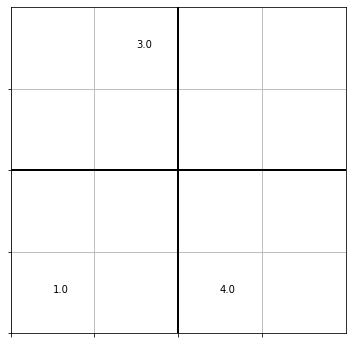

In [3]:
example1 = SudokuProblem(4)
example1._random()
example1._create_problem(3)
plot(example1.M)

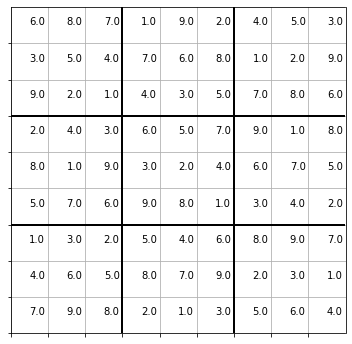

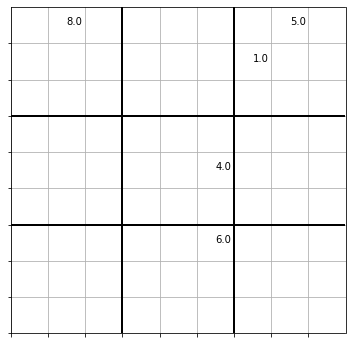

In [4]:
example2 = SudokuProblem(9)
example2._random()
plot(example2.M)
example2._create_problem(5)
plot(example2.M)

In [5]:
def is_valid(M, return_error = False, return_location = False):
    n = M.shape[0]
    location = []
    n_sq = int(np.sqrt(n))
    total_sum = n * (n - 1)/2
    error = 0
    #check rows
    for i in range(n):
        if len(np.unique(M[i, :])) != n:
            error+= 1

    #check columns
    for i in range(n):
        if len(np.unique(M[:, i])) != n:
            error+=1

    #check boxes
    for i in range(0, n, n_sq):
        for j in range(0, n, n_sq):
            if len(np.unique(M[i:i+n_sq, j:j+n_sq])) != n:
                error += 1
    
    if return_error and return_location:
        return error == 0, error, location
    
    if return_error:
        return error == 0, error
    if return_location:
        return error == 0, location
    
    return error == 0

## Busca em profundidade

In [6]:
def digit_is_valid(M, digit, i, j, return_error = False):
    n = M.shape[0]
    n_sq = int(np.sqrt(n))
    
    temp = M[i, j]
    M[i, j] = -1
    error = 0
    
    valid = True
    if digit > n:
        valid = False
        
    #row
    if np.where(M[i, :] == digit)[0].shape[0] > 0:
        error += 1
        valid = False

    #column
    if np.where(M[:, j] == digit)[0].shape[0] > 0:
        error += 1
        valid = False

    #box
    box_i = (i//n_sq) * n_sq
    box_j = (j//n_sq) * n_sq
    if np.where(M[box_i:box_i + n_sq, box_j:box_j + n_sq] == digit)[0].shape[0] > 0:
        error+=1
        valid = False
    
    M[i, j] = temp
    
    if return_error:
        return valid, error

    return valid

In [7]:
class Node:
    def __init__(self, M, i, j):
        self.M = M
        self.i = i
        self.j = j


def DFS(n, triples):
    n_sq = int(np.sqrt(n))
    M = np.zeros((n, n))
    for (i, j, digit) in triples:
        M[i, j] = digit
    
    checked = 0
    root = Node(M, -1, 0)
    stack = []
    stack.append(root)
    
    while len(stack) > 0:
        parent = stack.pop()
        
        #Compute next cell index
        next_i = parent.i + 1
        next_j = parent.j 
        if next_i >= n:
            next_i = 0
            next_j += 1
        #If it is a digit from a triple, it will have a value different than zero    
        while parent.M[next_i, next_j] != 0:
            next_i = next_i + 1
            if next_i >= n:
                next_i = 0
                next_j += 1
                
            if next_j >= n:
                print(f"Checked/total possibilities: {checked}/{n}^{n**2}=~1e{int(n**2*np.log10(n))}")
                return parent.M
        
        
        for digit in range(1, n+1):
            if digit_is_valid(parent.M, digit, next_i, next_j):
                child = Node(parent.M.copy(), next_i, next_j)
                child.M[next_i, next_j] = digit
                stack.append(child)

                if next_i == (n-1) and next_j == (n - 1):
                    print(f"Checked/total possibilities: {checked}/{n}^{n**2}=~1e{int(n**2*np.log10(n))}")
                    return child.M

            checked += 1
                
    return 

Checked/total possibilities: 1667/9^81=~1e77
Valid: True


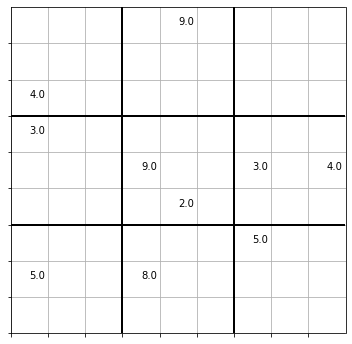

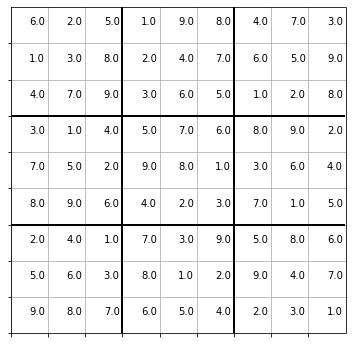

In [8]:
n = 9
k = 10
example3 = SudokuProblem(n)
example3._random()
triples = example3._create_problem(k)
plot(example3.M)
M = DFS(n, triples)
example3_solved = SudokuProblem(n)
example3_solved.M = M
plot(example3_solved.M)
print("Valid:",is_valid(M))

## Busca Local

In [9]:
def constructive_heuristic(n, triples):
    M = np.zeros((n, n))
    n_sq = int(np.sqrt(n))
    for (i, j, d) in triples:
        M[i, j] = d
        
    for j in range(n):
        for i in range(n):
            if M[i, j] == 0:
                tests_info = []
                for digit in range(1, n + 1):
                    valid, error = digit_is_valid(M, digit, i, j, True)
                    tests_info.append({'valid': valid, 'error': error, 'digit': digit})
                min_error = min([x['error'] for x in tests_info])
                tests_info = [x for x in tests_info if x['error'] == min_error]
                ind = np.random.randint(len(tests_info))
                digit = tests_info[ind]['digit']
                M[i, j] = digit
                    
          
    return M

In [10]:
def plot_colors(M):
    n = M.shape[0]
    n_sq = int(np.sqrt(n))
    fig = plt.figure(figsize = (6, 6))
    plt.xlim((0, n))
    plt.ylim((0, n))
    plt.xticks([i for i in range(n)], labels = ["" for i in range(n)])
    plt.yticks([i for i in range(n)], labels = ["" for i in range(n)])
    for i in range(1, n_sq):
        plt.hlines(y = n_sq * i, xmin = 0, xmax = n, colors = 'black', lw = 2)
        plt.vlines(x = n_sq * i, ymin = 0, ymax = n, colors = 'black', lw = 2)
    plt.grid()

    for i in range(n):
        for j in range(n):
            digit = M[i, j]
            if digit_is_valid(M, digit, i, j):
                plt.annotate(digit, xy = (i+0.5, j+0.5), color = 'green')
            else:
                plt.annotate(digit, xy = (i+0.5, j+0.5), color = 'red')
    return 

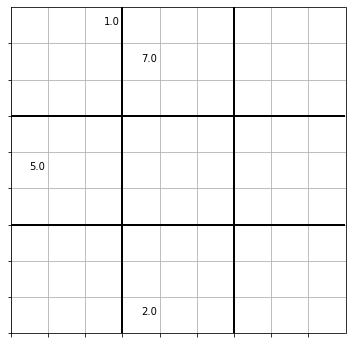

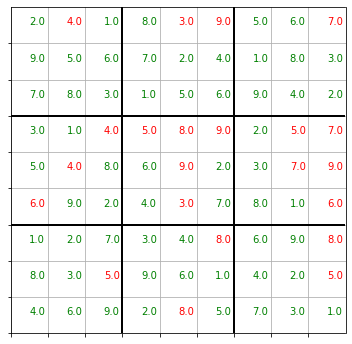

In [23]:
n = 9
k = 4
example4 = SudokuProblem(n)
example4._random()
triples = example4._create_problem(k)
plot(example4.M)

heuristic_solution = constructive_heuristic(n, triples)
example4_heuristic_solution = SudokuProblem(n)
example4_heuristic_solution.M = heuristic_solution
plot_colors(example4_heuristic_solution.M)

In [24]:
def local_search(M, triples):
    valid, error = is_valid(M, return_error = True)
    print("Initial error:", error)
    if valid:
        print("Already optimum.")
        return M
    
    n = M.shape[0]
    
    triples_ids = [(i, j) for (i, j, d) in triples]
    free_ids = []
    for i in range(n):
        for j in range(n):
            if (i, j) not in triples_ids:
                free_ids.append((i, j))

    
    while True:
        tests_info = []
        for (i, j) in free_ids:
            digit_old = M[i, j]
            _, error_old = digit_is_valid(M, digit_old, i, j, True)
            for digit_new in range(1, n+1):
                if digit_new != digit_old:
                    _, error_new = digit_is_valid(M, digit_new, i, j, True)

                    if error_old > error_new:
                        tests_info.append({'i': i, 'j': j,
                                           'digit_old': digit_old, 'digit_new': digit_new, 
                                           'error_old': error_old, 'error_new': error_new})
        
        if len(tests_info) == 0:
            print("Local optimum found.")
            valid, error = is_valid(M, return_error = True)
            print("Error:", error)
            return M
        
        min_error = min([x['error_new'] for x in tests_info])
        tests_info = [x for x in tests_info if x['error_new'] == min_error]
        picked_id = np.random.randint(len(tests_info))
        
        i = tests_info[picked_id]['i']
        j = tests_info[picked_id]['j']
        d = tests_info[picked_id]['digit_new']
        M[i, j] = d
                            
    return
                        
                

Initial error: 13
Local optimum found.
Error: 8


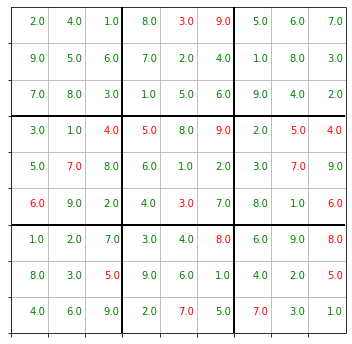

In [25]:
example4_local_search_solution = SudokuProblem(n)
example4_local_search_solution.M = local_search(example4_heuristic_solution.M.copy(), triples)
plot_colors(example4_local_search_solution.M)

## Algoritmo Genético

In [105]:
def genetic(n, M, triples,
            num_generations = 100,
            sol_per_pop = 20):
    
    n_sq = int(np.sqrt(n))
    k = len(triples)
    
    def is_valid_genetic(solution, solution_idx):
        M = np.zeros((n, n))
        for (i, j, d) in triples:
            M[i, j] = d

        c = 0
        for i in range(n):
            for j in range(n):
                if M[i, j] == 0:
                    M[i, j] = solution[c]
                    c+= 1

        error = 0
        #check rows
        for i in range(n):
            if len(np.unique(M[i, :])) != n:
                error+= 1

        #check columns
        for i in range(n):
            if len(np.unique(M[:, i])) != n:
                error+=1

        #check boxes
        for i in range(0, n, n_sq):
            for j in range(0, n, n_sq):
                if len(np.unique(M[i:i+n_sq, j:j+n_sq])) != n:
                    error += 1

        return -error
    
    num_genes = n**2 - k
    gene_type = np.int32
    init_range_low = 1 #lower threshold to generate random solutions
    init_range_high = n #upper thresold to generate random solutions
    gene_space = [i for i in range(1, n+1)]
    
    num_parents_mating = sol_per_pop//2 
    keep_parents =sol_per_pop//2
    fitness_function = is_valid_genetic
    parent_selection_type = 'rws'
    crossover_type = 'single_point'
    mutation_type = 'random'
    mutation_probability = 0.05
    crossover_probability = 0.4
    
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           gene_type = gene_type, 
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           #crossover_probability = crossover_probability,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_probability = mutation_probability,
                           gene_space = gene_space,
                          )
    
    ga_instance.run()
    ga_instance.plot_fitness()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Error:", -solution_fitness)
    M = np.zeros((n, n))
    for (i, j, d) in triples:
        M[i, j] = d

    c = 0
    for i in range(n):
        for j in range(n):
            if M[i, j] == 0:
                M[i, j] = solution[c]
                c+= 1
                
    return M

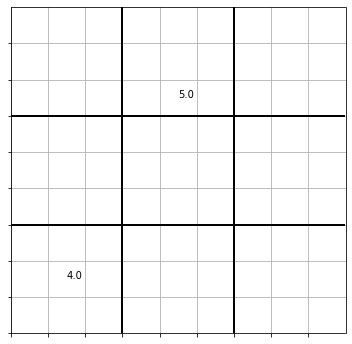

In [106]:
n = 9
n_sq = int(np.sqrt(n))
k = 2
example5 = SudokuProblem(n)
example5._random()
triples = example5._create_problem(k)
plot(example5.M)

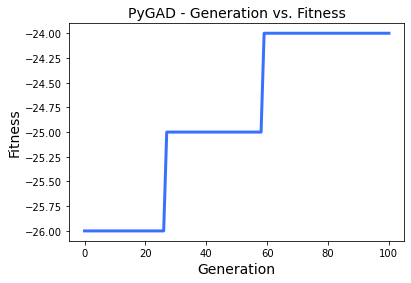

Error: 24


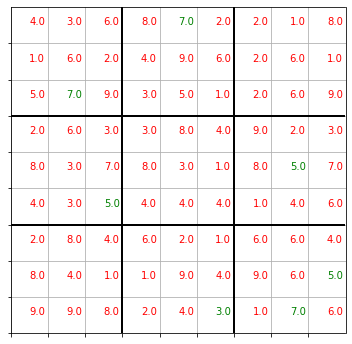

In [108]:
example5_genetic_solution = SudokuProblem(n)

example5_genetic_solution.M = genetic(n, M, triples, 100, 80)
plot_colors(example5_genetic_solution.M)